<a href="https://colab.research.google.com/github/Araujopri/Araujopri/blob/main/KMeans_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importando as bibliotecas necessárias
import pandas as pd
import numpy as np

In [ ]:
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
import warnings
warnings.filterwarnings("ignore")

np.random.seed(42)
pd.options.display.float_format = '{:.2f}'.format

In [ ]:
def make_spider(df_plot):
  num_col = df_plot.columns.difference(["cluster"])
  n_cols = df_plot['cluster'].unique().shape[0]
  df_plot[num_col] /= df_plot[num_col].max()
  df_plot = df_plot.fillna(0)

  palette = plt.cm.get_cmap("Set2", len(df_plot.index))

  categories = list(df_plot)[1:]
  N = len(categories)

  angles = [n/float(N)*2*np.math.pi for n in range(N)]
  angles += angles[:1]

  my_dpi = 96
  fig,axes = plt.subplots(df_plot.shape[0] // n_cols, n_cols, figsize=(1500/my_dpi, 1500/my_dpi), dpi=my_dpi, subplot_kw={"projection" : "polar"})
  axes = axes.ravel()

  for idx, ax in enumerate(axes):
    color = palette(idx)

    row = df_plot.iloc[idx]

    ax.set_theta_offset(np.math.pi / 2)
    ax.set_theta_direction(-1)

    ax.set_xticks(angles[:-1], categories, color="grey", size = 7)

    ax.set_rlabel_position(0)
    ax.set_yticks([0.33,0.66, 0.99], ["0.3", "0.6", "1"], color = "grey", size = 10)
    ax.set_ylim(0,1)

    values = row.drop("cluster").values.flatten().tolist()
    values += values[:1]

    ax.plot(angles, values, color = color, linewidth=1.5, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)

    ax.set_title(f"Persona {row['cluster']}", size=14, color = color, y=1.1)
  plt.tight_layout()
  plt.show()

## **Data Exploration**

In [ ]:
df = pd.read_csv("BankChurners.csv")
cols = list(df.columns)

n_linhas = df.shape[0]
print(f"A base de dados possui {n_linhas} linhas.")

print(f"Amostra de 10 linhas:")
df.sample(10)


A base de dados possui 10127 linhas.
Amostra de 10 linhas:


,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
3781,719455083,Existing Customer,48,F,3,Uneducated,Single,Less than $40K,Blue,39,...,2991.00,1508,1483.00,0.70,3734,64,0.88,0.50,0.00,1.00
2922,773503308,Existing Customer,59,M,1,Uneducated,Single,Less than $40K,Blue,53,...,2192.00,1569,623.00,0.71,4010,79,0.72,0.72,0.00,1.00
5070,715452408,Existing Customer,37,F,2,Graduate,Divorced,Less than $40K,Blue,36,...,1734.00,987,747.00,0.88,4727,67,0.91,0.57,0.00,1.00
7246,711264033,Existing Customer,47,M,3,Doctorate,Divorced,$40K - $60K,Blue,36,...,4786.00,1516,3270.00,0.94,4973,74,0.85,0.32,0.00,1.00
623,718943508,Existing Customer,42,M,3,Unknown,Single,$80K - $120K,Blue,33,...,3714.00,2170,1544.00,0.52,1454,35,0.52,0.58,0.00,1.00
3931,778247358,Existing Customer,65,M,1,Graduate,Single,Less than $40K,Blue,56,...,7636.00,0,7636.00,0.80,3880,67,0.81,0.00,0.00,1.00
4767,710431158,Existing Customer,52,F,3,Unknown,Single,Unknown,Blue,36,...,10273.00,1657,8616.00,0.71,3778,70,0.59,0.16,0.00,1.00
7094,715252383,Existing Customer,58,F,2,High School,Divorced,Unknown,Gold,36,...,34516.00,1864,32652.00,0.66,3595,52,0.73,0.05,0.00,1.00
3282,717189183,Existing Customer,35,M,1,Doctorate,Single,$40K - $60K,Blue,24,...,10467.00,1961,8506.00,0.71,2665,65,0.67,0.19,0.00,1.00
3994,712050933,Attrited Customer,48,M,4,College,Married,$80K - $120K,Blue,32,...,25190.00,0,25190.00,0.47,1533,41,0.32,0.00,0.99,0.01


In [ ]:
df_cat = df[["Attrition_Flag", "Gender", "Education_Level", "Marital_Status", "Income_Category", "Card_Category"]]

df_count = pd.concat([df_cat[col].value_counts() for col in df_cat], axis=1)

df_count.columns = df_cat.columns

print (df_count.to_string ())

                   Attrition_Flag  Gender  Education_Level  Marital_Status  Income_Category  Card_Category
Existing Customer         8500.00     NaN              NaN             NaN              NaN            NaN
Attrited Customer         1627.00     NaN              NaN             NaN              NaN            NaN
F                             NaN 5358.00              NaN             NaN              NaN            NaN
M                             NaN 4769.00              NaN             NaN              NaN            NaN
Graduate                      NaN     NaN          3128.00             NaN              NaN            NaN
High School                   NaN     NaN          2013.00             NaN              NaN            NaN
Unknown                       NaN     NaN          1519.00          749.00          1112.00            NaN
Uneducated                    NaN     NaN          1487.00             NaN              NaN            NaN
College                       NaN    

In [ ]:
#filtra a tabela
df = df[df['Income_Category'] != 'Unknown']
df = df[df['Marital_Status'] != 'Unknown']
df = df[df['Education_Level'] != 'Unknown']

In [ ]:
n_linhas = df.shape[0]
print(f"A base de dados possui {n_linhas} linhas.")

A base de dados possui 7081 linhas.


In [ ]:
#Apaga a coluna CLIENTNUM
df.drop(columns=['CLIENTNUM',], inplace=True)

# Aplicar one-hot encoding para 'Marital_Status'
df = pd.get_dummies(df, columns=['Marital_Status'], drop_first=True)

# Mapear para valores numéricos
df['Attrition_Flag'] = df['Attrition_Flag'].map({'Existing Customer': 0, 'Attrited Customer': 1})
df['Gender'] = df['Gender'].map({'F': 0, 'M': 1})
df['Education_Level'] = df['Education_Level'].map({'Uneducated': 0, 'High School': 1, 'College': 2, 'Graduate': 3, 'Post-Graduate': 4, 'Doctorate': 5})
df['Income_Category'] = df['Income_Category'].map({'Less than $40K': 20000, '$40K - $60K': 50000, '$60K - $80K': 70000, '$80K - $120K': 100000, '$120K +': 240000})
df['Card_Category'] = df['Card_Category'].map({'Blue': 1, 'Silver': 0, 'Gold':0, 'Platinum': 0})



In [ ]:

column_names = df.columns

column_list = list(column_names)

# Imprima os nomes das colunas numerados
for i, column in enumerate(column_list, start=1):
    print(f"{i}. {column}")

print()
print(f"Amostra de 10 linhas:")
df.sample(10)




1. Attrition_Flag
2. Customer_Age
3. Gender
4. Dependent_count
5. Education_Level
6. Income_Category
7. Card_Category
8. Months_on_book
9. Total_Relationship_Count
10. Months_Inactive_12_mon
11. Contacts_Count_12_mon
12. Credit_Limit
13. Total_Revolving_Bal
14. Avg_Open_To_Buy
15. Total_Amt_Chng_Q4_Q1
16. Total_Trans_Amt
17. Total_Trans_Ct
18. Total_Ct_Chng_Q4_Q1
19. Avg_Utilization_Ratio
20. Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1
21. Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
22. Marital_Status_Married
23. Marital_Status_Single

Amostra de 10 linhas:


,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,...,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2,Marital_Status_Married,Marital_Status_Single
3658,0,44,1,3,1,100000,1,29,6,3,...,33257.00,0.55,3275,67,0.59,0.04,0.00,1.00,0,1
2586,0,36,1,2,1,100000,1,26,4,2,...,14291.00,0.81,1687,40,0.74,0.11,0.00,1.00,1,0
331,0,50,0,1,3,20000,1,36,4,1,...,2770.00,0.82,1142,28,1.00,0.45,0.00,1.00,0,1
8879,0,45,1,3,3,70000,0,31,2,1,...,33007.00,0.73,7167,91,0.62,0.04,0.00,1.00,0,0
2688,0,31,0,2,0,20000,1,19,6,2,...,892.00,0.87,2697,68,0.79,0.69,0.00,1.00,0,0
1594,0,53,1,4,3,70000,1,44,3,2,...,649.00,0.81,1587,38,0.52,0.67,0.00,1.00,1,0
1810,0,37,1,3,0,100000,1,31,4,2,...,2372.00,1.50,2555,44,0.83,0.38,0.00,1.00,1,0
9912,0,42,1,3,1,100000,0,36,5,2,...,33222.00,0.68,13845,120,0.79,0.04,0.00,1.00,1,0
9285,1,32,1,1,1,50000,1,36,6,3,...,2685.00,0.83,9330,64,0.88,0.44,0.99,0.01,0,1
7877,0,45,1,2,4,70000,1,36,1,2,...,3930.00,0.81,3645,70,1.00,0.34,0.00,1.00,1,0


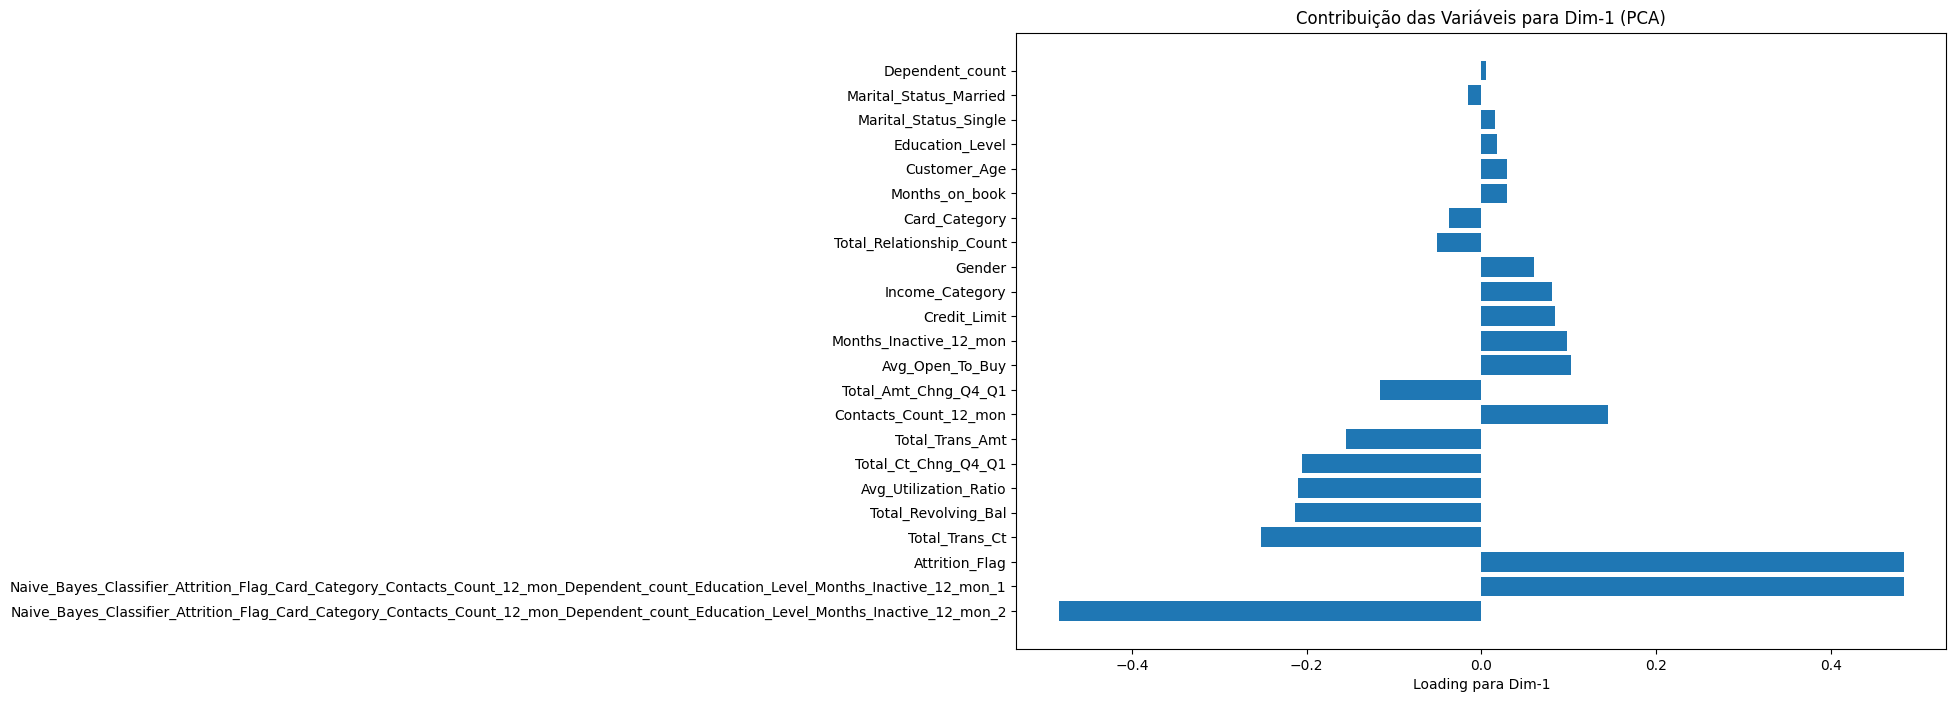

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Supondo que 'df' seja o seu DataFrame
# Substitua 'df' pelo nome real do seu DataFrame, se for diferente

# Selecionar apenas colunas numéricas
colunas_numericas = df.select_dtypes(include=['number']).columns

# Criar uma cópia do DataFrame apenas com as colunas numéricas
df_numericas = df[colunas_numericas].copy()

# Padronizar as variáveis numéricas (importante para PCA)
# se a distribuição dos seus dados não é normal ou se há outliers, a Z-score Normalization pode ser mais apropriada
scaler = StandardScaler()
df_numericas[colunas_numericas] = scaler.fit_transform(df[colunas_numericas])

# Especificar o número de componentes principais desejado (neste caso, 2)
n_componentes = 2

# Criar um objeto PCA
pca = PCA(n_components=n_componentes)

# Ajustar o modelo aos dados
pca.fit(df_numericas)

# Obter os pesos (loadings) das variáveis na primeira componente principal (Dim-1)
loadings_dim1 = pca.components_[0]

# Criar um DataFrame para visualizar os loadings
loadings_df = pd.DataFrame({'Variavel': colunas_numericas, 'Loading': loadings_dim1})

# Ordenar o DataFrame pelos valores absolutos dos loadings
loadings_df['Abs_Loading'] = loadings_df['Loading'].abs()
loadings_df = loadings_df.sort_values(by='Abs_Loading', ascending=False).drop(columns='Abs_Loading')

# Criar o gráfico de barras para visualizar a contribuição das variáveis para Dim-1
plt.figure(figsize=(12, 8))
plt.barh(loadings_df['Variavel'], loadings_df['Loading'])
plt.xlabel('Loading para Dim-1')
plt.title('Contribuição das Variáveis para Dim-1 (PCA)')
plt.show()


In [ ]:
colunas_para_excluir = ['Customer_Age', 'Gender', 'Dependent_count', 'Education_Level', 'Income_Category', 'Card_Category', 'Months_on_book', 'Total_Relationship_Count', 'Total_Amt_Chng_Q4_Q1', 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1', 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2', 'Marital_Status_Married', 'Marital_Status_Single']

# Verificar se as colunas existem no DataFrame antes de tentar excluí-las
colunas_existem = all(coluna in df.columns for coluna in colunas_para_excluir)

if colunas_existem:
    df.drop(columns=colunas_para_excluir, inplace=True)
    print("Colunas excluídas com sucesso.")
else:
    print("Algumas das colunas para exclusão não existem no DataFrame.")


Colunas excluídas com sucesso.


In [ ]:

novo_nome_colunas = {
    'Attrition_Flag': 'Status_conta',
    'Customer_Age': 'Idade_Cliente',
    'Gender': 'Genero',
    'Dependent_count': 'TOT_Dependentes',
    'Education_Level': 'escolaridade',
    'Income_Category': 'Categoria_Renda',
    'Card_Category': 'Categoria_Cartao',
    'Months_on_book': 'Meses_Relacionamento_Banco',
    'Total_Relationship_Count': 'TOT_PRD',
    'Months_Inactive_12_mon': 'Meses_Inativo_12_meses',
    'Contacts_Count_12_mon': 'interacao_ult_12_meses',
    'Credit_Limit': 'Limite_Credito',
    'Total_Revolving_Bal': 'Saldo_Total_Rotativo',
    'Avg_Open_To_Buy': 'Media_Disponivel_Para_Compras',
    'Total_Amt_Chng_Q4_Q1': 'Mudanca_Total_qtd_Q4_Q1',
    'Total_Trans_Amt': 'VL_Total_Transacao_12m',
    'Total_Trans_Ct': 'QTD_Total_Transacoes_12',
    'Total_Ct_Chng_Q4_Q1': 'qtd_tot_alteracoes_Q4_Q1',
    'Avg_Utilization_Ratio': 'MEDIA_UTIL_CARTAO',
    'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1': 'Naive_Bayes_Predicao_1',
    'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2': 'Naive_Bayes_Predicao_2',
    'Marital_Status_Divorced': 'Estado_Civil_Divorciado',
    'Marital_Status_Married': 'Estado_Civil_Casado',
    'Marital_Status_Single': 'Estado_Civil_Solteiro'
}

# Renomeie as colunas
df = df.rename(columns=novo_nome_colunas)




In [ ]:
n_linhas = df.shape[0]
print(f"A base de dados possui {n_linhas} linhas.")

A base de dados possui 7081 linhas.


In [ ]:
n_linhas = df.shape[0]
print(f"A base de dados possui {n_linhas} linhas.")

print(f"Amostra de 10 linhas:")
df.sample(10)

A base de dados possui 7081 linhas.
Amostra de 10 linhas:


,Status_conta,Meses_Inativo_12_meses,interacao_ult_12_meses,Limite_Credito,Saldo_Total_Rotativo,Media_Disponivel_Para_Compras,VL_Total_Transacao_12m,QTD_Total_Transacoes_12,qtd_tot_alteracoes_Q4_Q1,MEDIA_UTIL_CARTAO
4426,0,3,1,12248.00,1323,10925.00,4806,91,0.90,0.11
2477,0,3,3,2938.00,1995,943.00,1352,30,0.43,0.68
712,0,1,2,3880.00,1542,2338.00,1598,39,0.50,0.40
5728,0,1,2,1625.00,912,713.00,3968,73,0.70,0.56
2599,0,3,3,4838.00,1338,3500.00,2641,67,0.59,0.28
2319,0,3,2,34516.00,542,33974.00,3899,78,0.86,0.02
7098,0,2,3,3232.00,1346,1886.00,5102,69,0.64,0.42
9876,0,2,1,10325.00,0,10325.00,16856,122,0.72,0.00
6656,0,2,2,14314.00,656,13658.00,4355,70,0.67,0.05
1119,0,2,2,1438.30,0,1438.30,1999,39,0.56,0.00


## **Plots**

## Matriz de Correlação

In [ ]:
correlation_matrix = df.corr()

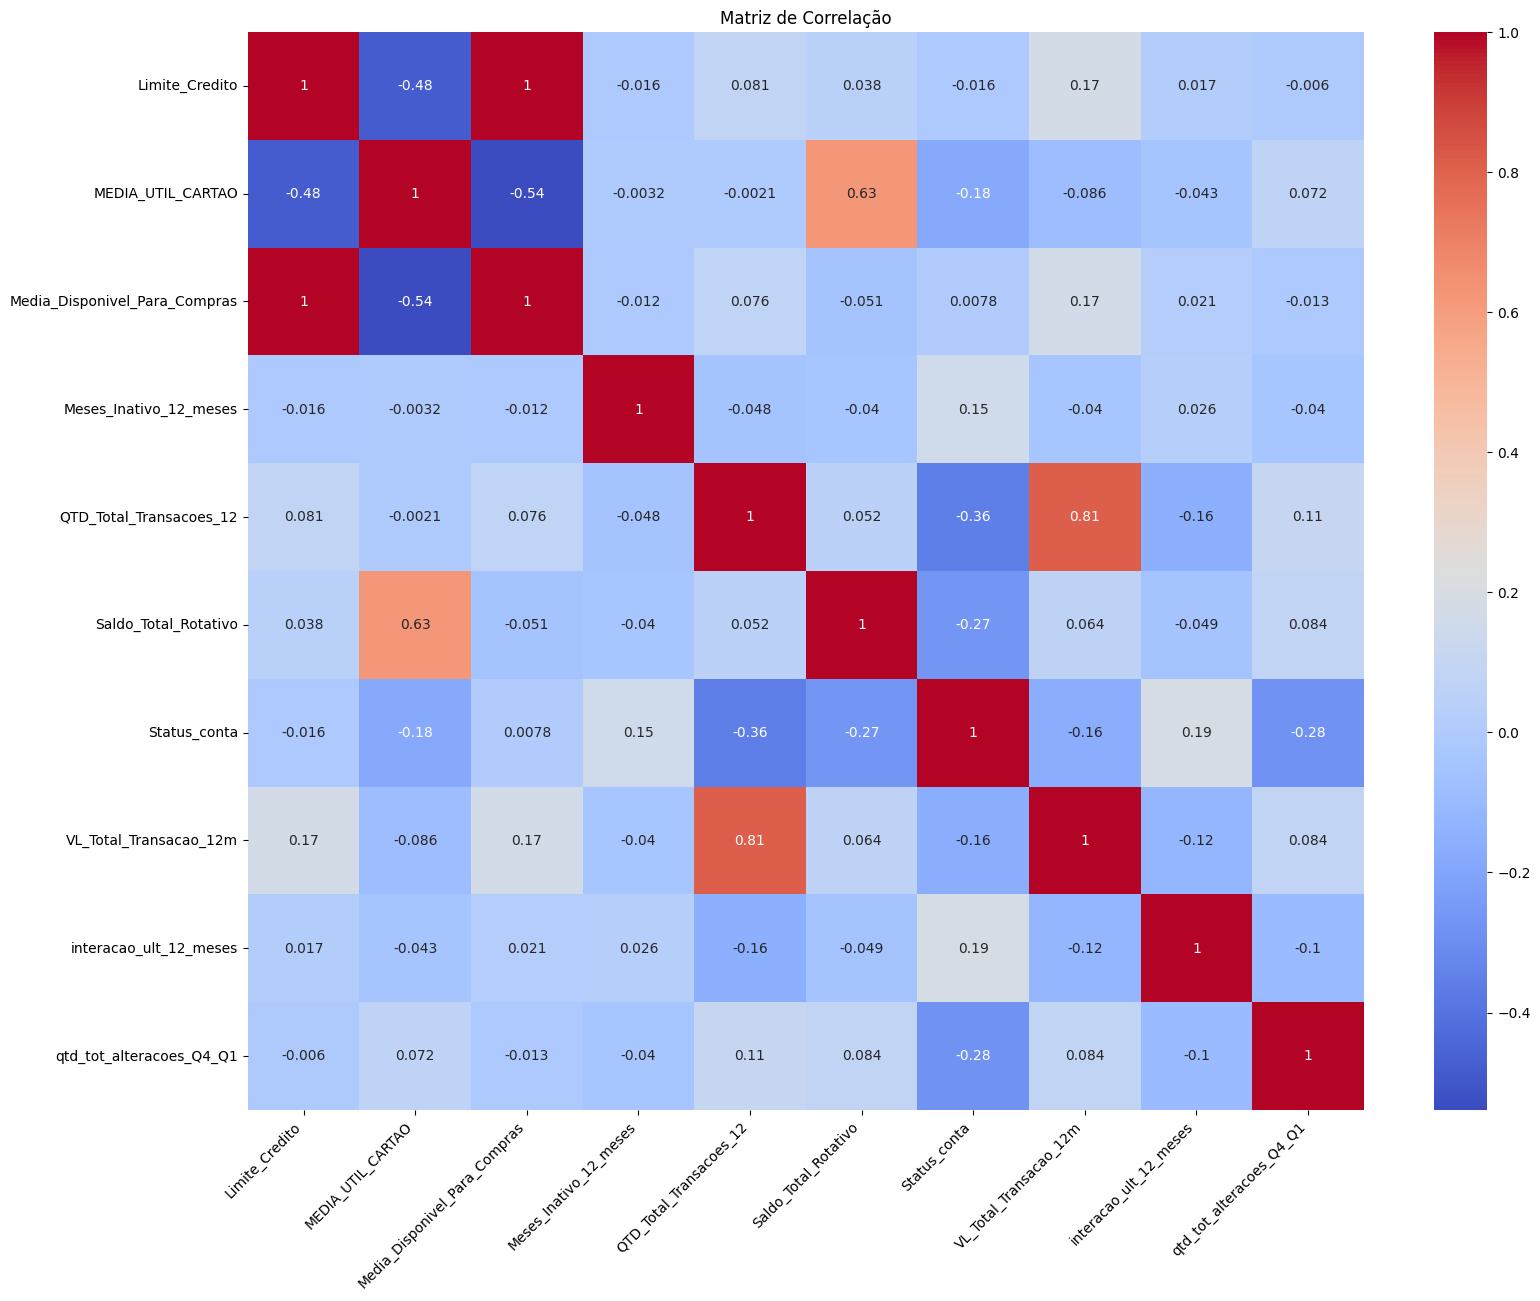

In [ ]:

# Ordenar as colunas do DataFrame pela ordem desejada
ordered_columns = df.columns.sort_values()

# Criar a matriz de correlação reordenada
correlation_matrix_ordered = df[ordered_columns].corr()

# Criar o gráfico de heatmap
plt.figure(figsize=(18, 14))
chart = sns.heatmap(correlation_matrix_ordered, annot=True, cmap="coolwarm")

# Ajustar manualmente a ordem das labels do eixo x
chart.set_xticklabels(ordered_columns, rotation=45, ha='right')

plt.title("Matriz de Correlação")
plt.show()


In [ ]:
df.columns

Index(['Status_conta', 'Meses_Inativo_12_meses', 'interacao_ult_12_meses',
       'Limite_Credito', 'Saldo_Total_Rotativo',
       'Media_Disponivel_Para_Compras', 'VL_Total_Transacao_12m',
       'QTD_Total_Transacoes_12', 'qtd_tot_alteracoes_Q4_Q1',
       'MEDIA_UTIL_CARTAO'],
      dtype='object')

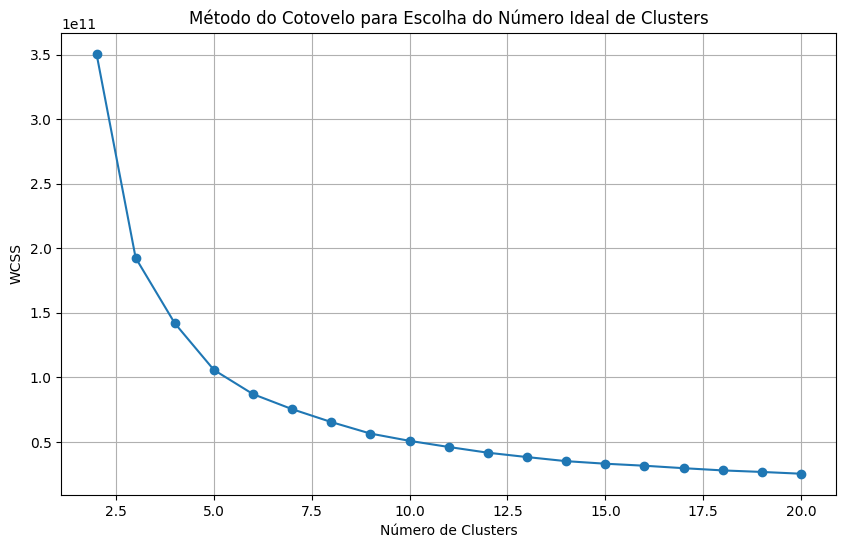

In [ ]:

# Supondo que df_cluster é o seu DataFrame
df_cluster = df.copy()

# Lista para armazenar as somas dos quadrados dentro dos clusters para cada k
wcss = []

# Testando k de 2 a 10
for i in range(2, 21):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(df_cluster)
    wcss.append(kmeans.inertia_)

# Plotando o gráfico do método do cotovelo
plt.figure(figsize=(10, 6))
plt.plot(range(2, 21), wcss, marker='o')
plt.title('Método do Cotovelo para Escolha do Número Ideal de Clusters')
plt.xlabel('Número de Clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()


In [ ]:
df_cluster = df.copy()

kmeans = KMeans(n_clusters = 5, random_state = 42, init = 'k-means++', n_init = 1)
kmeans.fit(df_cluster)

df_cluster["cluster"] = kmeans.predict(df_cluster)
df_cluster["cluster"] = [chr(x+65) for x in df_cluster.cluster]

In [ ]:
col_corte = ['qtd_tot_alteracoes_Q4_Q1',
       'MEDIA_UTIL_CARTAO']


df_cluster_info = df_cluster.groupby("cluster").median().reset_index()
df_cluster_count = df_cluster.groupby("cluster").count()[col_corte[0]].reset_index()
df_cluster_count.columns = ["cluster", "count"]

df_cluster_table = pd.merge(df_cluster_info, df_cluster_count, how="left", on="cluster")
df_cluster_table

,cluster,Status_conta,Meses_Inativo_12_meses,interacao_ult_12_meses,Limite_Credito,Saldo_Total_Rotativo,Media_Disponivel_Para_Compras,VL_Total_Transacao_12m,QTD_Total_Transacoes_12,qtd_tot_alteracoes_Q4_Q1,MEDIA_UTIL_CARTAO,count
0,A,0.00,2.00,3.00,9273.00,1235.50,8135.00,3096.50,60.00,0.68,0.13,1260
1,B,0.00,2.00,3.00,34516.00,1314.00,32723.00,3997.00,70.00,0.70,0.04,593
2,C,0.00,2.00,2.00,2689.00,1274.00,1438.30,3776.00,66.00,0.70,0.45,4133
3,D,0.00,2.00,2.00,18991.00,1229.00,17827.00,3677.00,66.00,0.69,0.06,691
4,E,0.00,2.00,2.00,5921.50,1465.00,4582.00,14519.50,108.00,0.74,0.21,404


<Axes: xlabel='f1', ylabel='f2'>

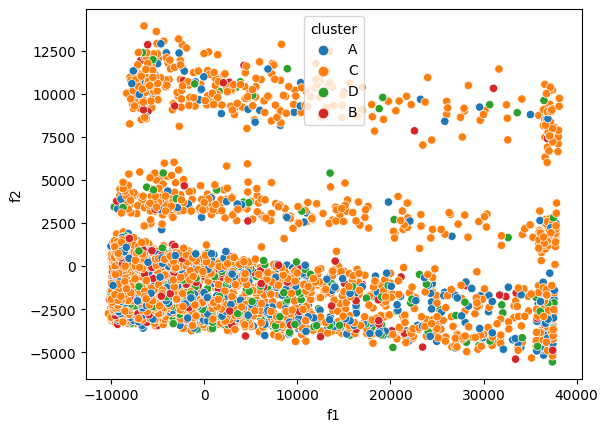

In [ ]:
pca = PCA(n_components=3)
X_transform = pca.fit_transform(df_cluster.drop("cluster", axis=1))
df_X_transform = pd.DataFrame(X_transform, columns = ["f1", "f2", "f3"])
df_X_transform["cluster"] = df_cluster["cluster"]


sns.scatterplot(data = df_X_transform, x="f1", y="f2", hue="cluster")


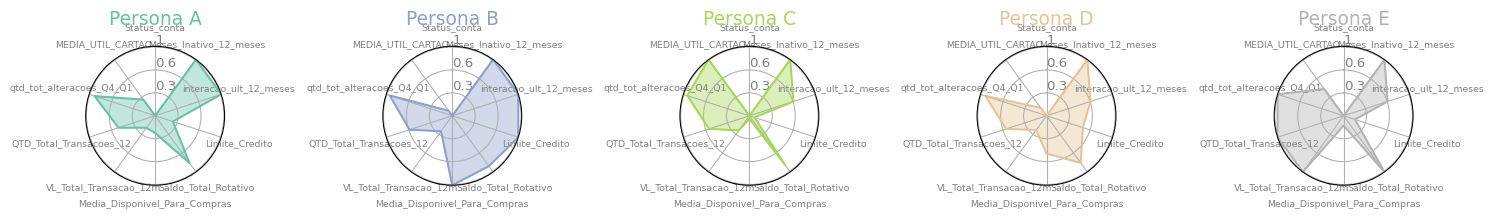

In [ ]:
make_spider(df_cluster_info)